# Clustering using GPU Accelerated DBSCAN in RAPIDS
#### By Paul Hendricks
-------

While the world’s data doubles each year, CPU computing has hit a brick wall with the end of Moore’s law. For the same reasons, scientific computing and deep learning has turned to NVIDIA GPU acceleration, data analytics and machine learning where GPU acceleration is ideal. 

NVIDIA created RAPIDS – an open-source data analytics and machine learning acceleration platform that leverages GPUs to accelerate computations. RAPIDS is based on Python, has pandas-like and Scikit-Learn-like interfaces, is built on Apache Arrow in-memory data format, and can scale from 1 to multi-GPU to multi-nodes. RAPIDS integrates easily into the world’s most popular data science Python-based workflows. RAPIDS accelerates data science end-to-end – from data prep, to machine learning, to deep learning. And through Arrow, Spark users can easily move data into the RAPIDS platform for acceleration.

In this notebook, we will also show how to use DBSCAN - a popular clustering algorithm - and how to use the GPU accelerated implementation of this algorithm in RAPIDS.

**Table of Contents**

* Clustering with DBSCAN
* Setup
* Generating Data
* K Means and Agglomerative Clustering
* Clustering using DBSCAN
* Accelerating DBSCAN with RAPIDS
* Benchmarking: Comparing GPU and CPU
* Conclusion

Before going any further, let's make sure we have access to `matplotlib`, a popular Python library for data visualization.

In [1]:
import os

try:
    import matplotlib
except ModuleNotFoundError:
    os.system('conda install -y matplotlib')

## Clustering with DBSCAN

Clustering is an important technique for helping data scientists partition data, especially when that data doesn't have labels or annotations associated with it. Since these data often don't have labels, clustering is often described as an unsupervised learning technique. While there are many different algorithms that partition data into unique clusters, we will show in this notebook how in certain cases the DBSCAN algorithm can do a better job of clustering than traditional algorithms such as K Means or Agglomerative Clustering. 

We will also show how to cluster data with DBSCAN in NVIDIA RAPIDS – an open-source data analytics and machine learning acceleration platform that leverages GPUs to accelerate computations. RAPIDS is based on Python, has pandas-like and Scikit-Learn-like interfaces, is built on Apache Arrow in-memory data format, and can scale from 1 to multi-GPU to multi-nodes. We will see that porting this example from CPU to GPU is trivial and that we can experience massive performance gains by doing so.

## Setup

This notebook was tested using the `nvcr.io/nvidia/rapidsai/rapidsai:0.5-cuda10.0-runtime-ubuntu18.04-gcc7-py3.7` Docker container from [NVIDIA GPU Cloud](https://ngc.nvidia.com) and run on the NVIDIA Tesla V100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [2]:
!nvidia-smi

Tue May  7 00:34:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:15:00.0 Off |                  Off |
| 29%   40C    P2    26W / 250W |  10149MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GV100        Off  | 00000000:2D:00.0  On |                  Off |
| 33%   46C    P0    29W / 250W |    260MiB / 32470MiB |     24%      Default |
+-------------------------------+----------------------+----------------------+
        

Next, let's see what CUDA version we have:

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


Next, let's load some helper functions from `matplotlib` and configure the Jupyter Notebook for visualization.

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


%matplotlib inline

## Generating Data

We'll generate some fake data using the `make_moons` function from the `sklearn.datasets` module. This function generates data points from two equations, each describing a half circle with a unique center. Since each data point is generated by one of these two equations, the cluster each data point belongs to is clear. The ideal clustering algorithm will identify two clusters and associate each data point with the equation that generated it.

In [5]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=int(1e2), noise=0.05, random_state=0)
print(X.shape)

(100, 2)


Let's visualize our data:

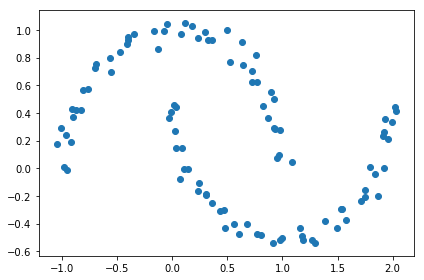

In [6]:
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

## K Means and Agglomerative Clustering

There exist several algorithms for partitioning data into partitions, two of the more common of which are called K Means and Agglomerative Clustering.

The K Means algorithm approaches the clustering problem by partitioning a set of data points into disjoint clusters, where each cluster is described by the mean of the samples in the cluster. The mean of the samples in a particular cluster is called a centroid; the K Means algorithm finds the centroids and associates data points with centroids in such a way as to minimize the within-cluster sum-of-squares.

For more information on the K Means algorithm and its implementatin in scikit-learn, check out this resource: http://scikit-learn.org/stable/modules/clustering.html#k-means

In the code cell below, we instantiate the `KMeans` algorithm from the `sklearn.cluster` module and apply it to our data using the `fit_predict` method. We see that `KMeans` identifies two centroids; one located at about (-0.23, 0.56) and the other located at (1.17, -0.05).

In [7]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
print(km.cluster_centers_)

[[ 1.17408322 -0.05027964]
 [-0.23011109  0.56790752]]


The Agglomerative Clustering algorithm behaves a little bit differently and does not identify clusters using centroids. Instead, it recursively merges the pair of clusters that minimally increases a given linkage distance. Put another way, the Agglomerative Clustering algorithm identifies the two data points that are "closest" out of all the data samples. It then takes those two data points and identifies a third data point that is "closest" to those two data points. The algorithm continues in this fashion for each data point; finding the next data point that is "closest" to the preceeding cluster of data points, where the definition of "closest" depends on the distance metric chosen.

For more information on the Agglomerative Clustering algorithm and its implementatin in scikit-learn, check out this resource: http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

Below, we instantiate the `AgglomerativeClustering` algorithm from the `sklearn.cluster` module and apply it to our data.

In [8]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)

We can visualize the results of both algorithms applied to the data. Visually, we see that neither algorithm ideally clusters our data. The ideal algorithm for this unique set of data would recognize that both sets of samples are generated from two different equations describing two different half circles.

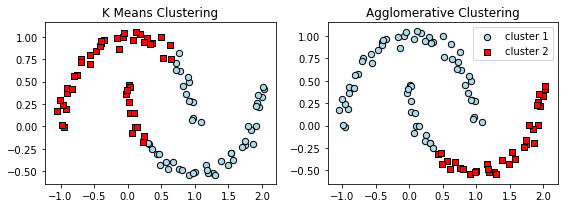

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))


ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K Means Clustering')


ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative Clustering')

plt.legend()
plt.tight_layout()
plt.show()

## Clustering using DBSCAN

Unlike K Means or Agglomerative Clustering, DBSCAN is a density-based approach to spatial clustering. It views clusters as areas of high density separated by areas of low density. This approach has several advantages; whereas K Means focuses on finding centroids and assoicating data points with that centroid in a spherical manner, the DBSCAN algorithm can identify clusters of any convex shape. Additionally, DBSCAN is robust to areas of low density. In the above visualization, we see that Agglomerative Clustering ignores the low density space space between the interleaving circles and instead focuses on finding a clustering hierarchy that minimizes the Euclidean distance. While minimizing Euclidean distance is important for some clustering problems, it is visually apparent to a human that following the density trail of points results in the ideal clustering. 

For more information on the DBSCAN algorithm and its implementation in scikit-learn, check out this resource: http://scikit-learn.org/stable/modules/clustering.html#dbscan

In [10]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=2)

Next, let's fit our model to the data and generate predictions.

In [11]:
y_db = db.fit_predict(X)

Lastly, let's visualize the model applied to our data. We see that the DBSCAN algorithm correctly identifies which half-circle each data point is generated from.

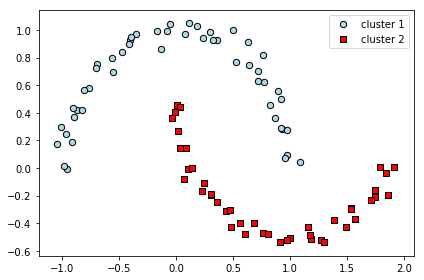

In [12]:
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

## Accelerating DBSCAN with RAPIDS

While the world’s data doubles each year, CPU computing has hit a brick wall with the end of Moore’s law. For the same reasons, scientific computing and deep learning has turned to NVIDIA GPU acceleration, data analytics and machine learning where GPU acceleration is ideal. 

NVIDIA created RAPIDS – an open-source data analytics and machine learning acceleration platform that leverages GPUs to accelerate computations. RAPIDS is based on Python, has pandas-like and Scikit-Learn-like interfaces, is built on Apache Arrow in-memory data format, and can scale from 1 to multi-GPU to multi-nodes. RAPIDS integrates easily into the world’s most popular data science Python-based workflows. RAPIDS accelerates data science end-to-end – from data prep, to machine learning, to deep learning. And through Arrow, Spark users can easily move data into the RAPIDS platform for acceleration.

So how do we use RAPIDS? First, we cast our data to a `pandas.DataFrame` and use that to create a `cudf.DataFrame`. 

In [13]:
import pandas as pd
import cudf

X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

Next, we load the `DBSCAN` class from the `cuml` package and instantiate it in the same way we did with the `sklearn.cluster.DBSCAN` class.

In [14]:
from cuml import DBSCAN as cumlDBSCAN

db_gpu = cumlDBSCAN(eps=0.2, min_samples=2)

The `DBSCAN` class from `cuml` implements the same API as the `sklearn` version; we can use the `fit` and `fit_predict` methods to fit our `DBSCAN` model to the data and generate predictions.

In [15]:
y_db_gpu = db_gpu.fit_predict(X_gpu)

Lastly, let's visualize our results:

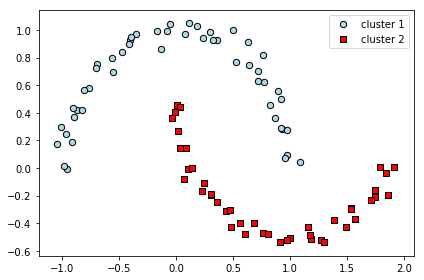

In [16]:
plt.scatter(X[y_db_gpu == 0, 0], X[y_db_gpu == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db_gpu == 1, 0], X[y_db_gpu == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

## Benchmarking: Comparing GPU and CPU

RAPIDS uses GPUs to parallelize operations and accelerate computations. We saw porting an example from the traditional scikit-learn interface to cuML was trivial. So how much speedup do we get from using RAPIDS? 

The answer to this question varies depending on the size and shape of the data. In the below example, we generate a matrix of 10,000 rows by 128 columns and show we were able to reduce computational time from ~45 seconds to ~5 seconds - almost a 9x speedup. Feel free to change the number of rows and columns to see how this speedup might change depending on the size and shape of the data.

As a good rule of thumb, larger datasets will benefit from RAPIDS. There is overhead associated with using a GPU; data has to be transferred from the CPU to the GPU, computations have to take place on the GPU, and the results need to be transferred back from the GPU to the CPU. However, the transactional overhead of moving data back and forth from the CPU to the GPU can quickly become negligible due to the performance speedup from computing on a GPU instead of a CPU.

In [17]:
import numpy as np

n_rows, n_cols = 10000, 128
X = np.random.rand(n_rows, n_cols)
print(X.shape)

(10000, 128)


### GPU

In [18]:
X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

In [19]:
db_gpu = cumlDBSCAN(eps=3, min_samples=2)

In [20]:
%%time

y_db_gpu = db_gpu.fit_predict(X_gpu)

CPU times: user 181 ms, sys: 39.1 ms, total: 220 ms
Wall time: 219 ms


### CPU

In [21]:
db = DBSCAN(eps=3, min_samples=2)

In [22]:
%%time

y_db = db.fit_predict(X)

CPU times: user 26.1 s, sys: 5.04 ms, total: 26.1 s
Wall time: 26.1 s


## Conclusion

In conclusion, there are certain cases the DBSCAN algorithm can do a better job of clustering than traditional algorithms such as K Means or Agglomerative Clustering. Additionally, porting DBSCAN from CPU to GPU using RAPIDS is a trivial exercise and can yield massive performance gains.

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)


Disclaimer: The above examples borrowed code snippets from *Python Machine Learning, 2nd Ed.* by Sebastian Raschka and Vahid Mirjalili. For a great deep dive into these concepts, the curious reader is strongly encouraged to explore that fantastic resource.